In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CS231n/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS231n/assignment1/cs231n/datasets
/content/drive/My Drive/CS231n/assignment1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS231n/assignment1/cs231n/datasets
/content/drive/My Drive/CS231n/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram, i.e. 

# The hog_feature and color_histogram_hsv functions both operate on a single image 
# and return a feature vector for that image.
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

# The extract_features function takes a set of images and a list of feature functions 
# and evaluates each feature function on each image, storing the results in a matrix 
# where each column is the concatenation of all feature vectors for a single image.
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
# np.hstack((arr0, arr1,…)): return an array horizontally concatenating given arrays of the same # rows
#	np.ones((D,H)): return an array of size [DxH], with 1 as all elements.

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rate in learning_rates: 
  for  regularization_strength in regularization_strengths: 
    # initialize the LinearSVM object! 
    svm = LinearSVM()
    # do the trainning
    svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength,
                        num_iters=1000, verbose=True)

    # do the prediction
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)

    # eveluate the accuracies
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)

    # store the accuracies
    results[(learning_rate, regularization_strength)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val: 
      best_val = validation_accuracy
      best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 1000: loss 47.386452
iteration 100 / 1000: loss 47.003178
iteration 200 / 1000: loss 46.618857
iteration 300 / 1000: loss 46.256243
iteration 400 / 1000: loss 45.879376
iteration 500 / 1000: loss 45.513530
iteration 600 / 1000: loss 45.152989
iteration 700 / 1000: loss 44.784498
iteration 800 / 1000: loss 44.433648
iteration 900 / 1000: loss 44.088346
iteration 0 / 1000: loss 392.444054
iteration 100 / 1000: loss 355.934059
iteration 200 / 1000: loss 322.905262
iteration 300 / 1000: loss 293.021850
iteration 400 / 1000: loss 265.990384
iteration 500 / 1000: loss 241.535821
iteration 600 / 1000: loss 219.397454
iteration 700 / 1000: loss 199.377275
iteration 800 / 1000: loss 181.256086
iteration 900 / 1000: loss 164.863146
iteration 0 / 1000: loss 3778.966692
iteration 100 / 1000: loss 1392.416740
iteration 200 / 1000: loss 516.653531
iteration 300 / 1000: loss 195.288083
iteration 400 / 1000: loss 77.358023
iteration 500 / 1000: loss 34.085572
iteration 600 / 1000: loss 1

In [8]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


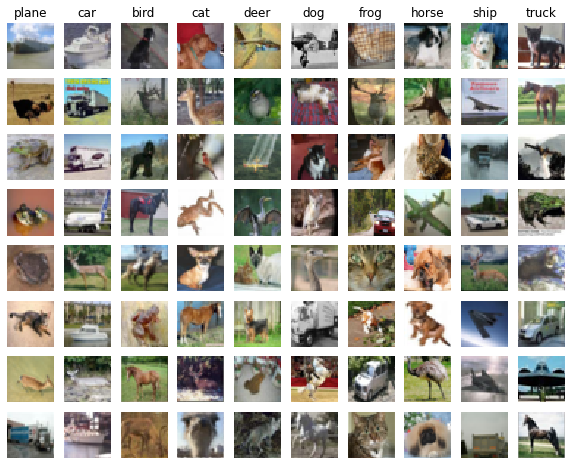

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ 

Totally NOT.

**Correction** : 
Since we are using The color histogram features and the HOG features for some misclassification results which have special background or outline, they do make sense. For example, the objects which have a blue background tend to be misclassified as plane and some dogs(trucks) tend be misclassified as cat(car).





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


**I got some problems when I was coding in the cells below.**

1) 
After completing the two layer neural network in fc_net.py, and trainning it: 

**It trun out best accracy is ~ 0.1 no matter much many trainning data were used (I set a mask to make the trainning faster), and the loss converged at ~2.**

How could it happen?

**Solution:** 

I set the hyperparemeters:

learning_rates = [1e-9, 1e-8, 1e-7] 
and 
regularization_strengths = [5e4, 5e5, 5e6]

**The learning rates were too small and the regularization strengths were too big. That explained pretty much of it.**

After setting those hyperparameters at: 

learning_rates = [1.0]
and 
regularization_strengths = [1e-3, 3e-3]

Solved. 

2) The second problem: 

Now accuracy gets stuck at ~ 0.3. 

**Solution:**

The mask. With a small amount of data set it's easier to get over-fitting and that leads to a smaller testing accuracy. 

It becomes okay when I use all the trainning data to train the model (49,000 data points). 


In [ ]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

# # Use a small subset of the training set so our code runs faster.
# num_training = X_train_feats.shape[0]
# num_dev = 150
# # Randomly selected num_dev data poirnts from the whole training set. 
# mask = np.random.choice(num_training, num_dev, replace=False)

data = {
    # 'X_train': X_train_feats[mask], 
    # 'y_train': y_train[mask], 
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

best_net = None
best_acc = 0
results = {}
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# learning_rates = [1e-7, 1e-5, 1e-3, 1e-1]
# regularization_strengths = [1e-3, 1e-2, 1e-1]

learning_rates = [1.0]
regularization_strengths = [1e-3, 3e-3]

for learning_rate in learning_rates: 
  for  regularization_strength in regularization_strengths: 
      # initialize the TwoLayerNet object
      net = TwoLayerNet(input_dim, hidden_dim, num_classes)

      # do the trainning
      net.train(data['X_train'], data['y_train'], 
                learning_rate=learning_rate, reg=regularization_strength, num_iters=1000)

      # do the prediction
      y_train_pred = net.predict(data['X_train'])
      y_val_pred = net.predict(data['X_val'])

      # eveluate the accuracies
      training_accuracy = np.mean(data['y_train'] == y_train_pred)
      validation_accuracy = np.mean(data['y_val'] == y_val_pred)

      # store the accuracies
      results[(learning_rate, regularization_strength)] = (training_accuracy, validation_accuracy)

      if validation_accuracy > best_acc: 
        best_acc = validation_accuracy
        best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0: loss 2.302629
iteration 100: loss 1.321942
iteration 200: loss 1.207112
iteration 300: loss 1.126530
iteration 400: loss 1.083043
iteration 500: loss 1.035967
iteration 600: loss 0.995233
iteration 700: loss 0.957289
iteration 800: loss 0.917607
iteration 900: loss 0.890134
iteration 0: loss 2.302697
iteration 100: loss 1.361740
iteration 200: loss 1.278401
iteration 300: loss 1.231092
iteration 400: loss 1.210559
iteration 500: loss 1.183443
iteration 600: loss 1.164837
iteration 700: loss 1.145267
iteration 800: loss 1.175146
iteration 900: loss 1.149334


In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = best_net.predict(data['X_test'])
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.595
